<a href="https://colab.research.google.com/github/almejiaga/Exome_analysis/blob/main/Ancestry_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic ancestry estimation from vcf files
### Here we are going to learn how to estimate genetic ancestry from a vcf file. We need to follow these steps:


1.   Download plink2
2.   Download the data
3.   convert to plink binary files
4.   Perform quality control
5.   Download admixture
6.   Run Admixture
7.   Plot results




In [ ]:
#1. Download plink2
!wget https://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_20240818.zip
!unzip plink2_linux_x86_64_20240818.zip
!./plink2

--2024-09-10 02:18:12--  https://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_20240818.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.61.168, 52.217.91.102, 3.5.12.50, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.61.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9345987 (8.9M) [application/zip]
Saving to: ‘plink2_linux_x86_64_20240818.zip’

plink2_linux_x86_64 100%[===================>]   8.91M  19.6MB/s    in 0.5s    

2024-09-10 02:18:13 (19.6 MB/s) - ‘plink2_linux_x86_64_20240818.zip’ saved [9345987/9345987]

Archive:  plink2_linux_x86_64_20240818.zip
  inflating: plink2                  
PLINK v2.00a6LM 64-bit Intel (18 Aug 2024)     www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink2 <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink2 --help [flag name(s)...]

Commands include --rm-dup list, --make-bpgen, --export, --freq, --geno-co

## 2. Download the data

---


I prepared a github repository with vcf files from 1000 genomes dataset (only coding regions). For this analysis, I restricted the original vcf files (found here:https://www.cog-genomics.org/plink/2.0/resources) to the bed file provided by agilent kit for exome sequencing: SureSelectXT Human All Exon V8 (https://www.agilent.com/en/product/next-generation-sequencing/ngs-assays-panels/exome/sureselect-human-all-exon-4252439).

In [ ]:
!git clone https://github.com/almejiaga/Exome_analysis.git

Cloning into 'Exome_analysis'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 48 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 43.96 MiB | 7.14 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (8/8), done.


## Explanation of files
### exome.vcf.gz: subset of 1000 genomes dataset and HGDP, restricted to coding regions (exome, filtered using an a bed file from exome sequencing library)

## 3. converting to binary plink files
### We need to do a quality control of data, and for that, we need to convert vcf files to binary plink files, which have .bim, .fam and .bed (non-readable for humans, do not open)


In [ ]:
!./plink2 --vcf Exome_analysis/exome.vcf.gz --make-bed --out exome_data

PLINK v2.00a6LM 64-bit Intel (18 Aug 2024)     www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to exome_data.log.
Options in effect:
  --make-bed
  --out exome_data
  --vcf Exome_analysis/exome.vcf.gz

Start time: Tue Sep 10 02:18:32 2024
12978 MiB RAM detected, ~11660 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
--vcf: 244305 variants scanned.
--vcf: exome_data-temporary.pgen + exome_data-temporary.pvar.zst +
exome_data-temporary.psam written.
969 samples (0 females, 0 males, 969 ambiguous; 969 founders) loaded from
exome_data-temporary.psam.
244305 variants loaded from exome_data-temporary.pvar.zst.
Note: No phenotype data present.
Writing exome_data.fam ... done.
Writing exome_data.bim ... done.
Writing exome_data.bed ... 0%26%53%80%done.
End time: Tue Sep 10 02:18:39 2024


## 4. Quality control and LD prunning

We are going to use a standard quality control procedure that keep variants:


*   Frequency of at least 1%
*   Call rate of at least 90% (At least in 90% of individuals)
*   in Hardy-Weinberg equilibrium

And also individuals:
* At least 90% of the variants are non-missing

For LD prunning:


*   Windows of 50 variants, with 5 variants between windows (50 5)
*   We will remove variants with a R2 bigger than 0.2










In [ ]:
!./plink2 --bfile exome_data \
--maf 0.01 \
--geno 0.1 \
--mind 0.1 \
--hwe 0.0001 \
--make-bed \
--out admixture_maf-0.01_geno-0.1_hwe-1e4

# Perform LD pruning in two steps:
# Step 1: Generate list of SNPs to keep
# We perform linkage disequilibrium (LD) pruning using:
  # - a window size of 50 SNPs
  # - a step size of 5 SNPs
  # - r2 threshold of 0.2 (correlation between SNPs)
!./plink2 --bfile admixture_maf-0.01_geno-0.1_hwe-1e4 \
       --indep-pairwise 50 5 0.2 \
       --out ld_pruned

# Step 2: Apply LD pruning
!./plink2 --bfile admixture_maf-0.01_geno-0.1_hwe-1e4 \
       --extract ld_pruned.prune.in \
       --make-bed \
       --out admixture_LD_QC

PLINK v2.00a6LM 64-bit Intel (18 Aug 2024)     www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to admixture_maf-0.01_geno-0.1_hwe-1e4.log.
Options in effect:
  --bfile exome_data
  --geno 0.1
  --hwe 0.0001
  --maf 0.01
  --make-bed
  --mind 0.1
  --out admixture_maf-0.01_geno-0.1_hwe-1e4

Start time: Tue Sep 10 02:18:43 2024
12978 MiB RAM detected, ~11638 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
969 samples (0 females, 0 males, 969 ambiguous; 969 founders) loaded from
exome_data.fam.
244305 variants loaded from exome_data.bim.
Note: No phenotype data present.
Calculating sample missingness rates... 0%26%53%80%done.
0 samples removed due to missing genotype data (--mind).
969 samples (0 females, 0 males, 969 ambiguous; 969 founders) remaining after
main filters.
Calculating allele frequencies... 0%26%53%80%done.
--geno: 0 variants removed due to missing g

##  5. Download admixture

In [ ]:
!wget https://dalexander.github.io/admixture/binaries/admixture_linux-1.3.0.tar.gz
!tar -xvzf admixture_linux-1.3.0.tar.gz

--2024-09-10 02:19:01--  https://dalexander.github.io/admixture/binaries/admixture_linux-1.3.0.tar.gz
Resolving dalexander.github.io (dalexander.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to dalexander.github.io (dalexander.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1916705 (1.8M) [application/gzip]
Saving to: ‘admixture_linux-1.3.0.tar.gz’

admixture_linux-1.3 100%[===================>]   1.83M  --.-KB/s    in 0.07s   

2024-09-10 02:19:02 (26.0 MB/s) - ‘admixture_linux-1.3.0.tar.gz’ saved [1916705/1916705]

dist/admixture_linux-1.3.0/
dist/admixture_linux-1.3.0/README.32.txt
dist/admixture_linux-1.3.0/admixture
dist/admixture_linux-1.3.0/admixture32
dist/admixture_linux-1.3.0/admixture-manual.pdf


## 6. Run admixture

We will run admixture using the binary plink files. We will use the unsupervised mode and a k=4, which is the number of ancestral populations

In [ ]:
!./dist/admixture_linux-1.3.0/admixture admixture_LD_QC.bed 3

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 969x56823
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 5.913	Loglikelihood: -2.86474e+07	(delta): 6.01115e+07
2 (EM) 	Elapsed: 8.812	Loglikelihood: -2.7245e+07	(delta): 1.40241e+06
3 (EM) 	Elapsed: 10.

In [ ]:
!head admixture_LD_QC.3.Q

0.187904 0.000010 0.812086
0.299837 0.095333 0.604830
0.047245 0.000010 0.952745
0.136391 0.000010 0.863599
0.052031 0.000010 0.947959
0.113791 0.000010 0.886199
0.019116 0.006202 0.974682
0.119470 0.000541 0.879989
0.084750 0.000010 0.915240
0.035836 0.000010 0.964154


In [ ]:
!head admixture_LD_QC.fam

0	ACB_ACB1	0	0	0	-9
0	ACB_ACB2	0	0	0	-9
0	ACB_ACB3	0	0	0	-9
0	ACB_ACB4	0	0	0	-9
0	ACB_ACB5	0	0	0	-9
0	ACB_ACB6	0	0	0	-9
0	ACB_ACB7	0	0	0	-9
0	ACB_ACB8	0	0	0	-9
0	ACB_ACB9	0	0	0	-9
0	ACB_ACB10	0	0	0	-9


## 7. Plotting the results

We are using a python notebook, so we will plot results in python

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the files
ld_qc_df = pd.read_csv('admixture_LD_QC.3.Q', delim_whitespace=True, header=None)
fam_df = pd.read_csv('admixture_LD_QC.fam', delim_whitespace=True, header=None)

# Extract population information from the fam file
fam_df['IID'] = fam_df[1]
fam_df['population'] = fam_df[1].apply(lambda x: x.split('_')[0])

# Combine the dataframes
ld_qc_df.columns = ['Column1', 'Column2', 'Column3']
combined_df = pd.concat([fam_df, ld_qc_df], axis=1)

# Rename columns for clarity
#combined_df.columns = ['FID', 'IID', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', 'Column10']
#combined_df = combined_df[['IID', 'Column1', 'Column2', 'Column3', 'Column4']]

# Set 'IID' as index
combined_df.set_index(1, inplace=True)

# Create a new column for population
#combined_df['Population'] = combined_df['1']

In [ ]:
combined_df

,0,2,3,4,5,IID,population,Column1,Column2,Column3,Column4
1,,,,,,,,,,,
ACB_ACB1,0,0,0,0,-9,ACB_ACB1,ACB,0.188835,0.000010,0.163418,0.647737
ACB_ACB2,0,0,0,0,-9,ACB_ACB2,ACB,0.303544,0.095304,0.065173,0.535979
ACB_ACB3,0,0,0,0,-9,ACB_ACB3,ACB,0.047092,0.000010,0.105710,0.847188
ACB_ACB4,0,0,0,0,-9,ACB_ACB4,ACB,0.136683,0.000010,0.180361,0.682945
ACB_ACB5,0,0,0,0,-9,ACB_ACB5,ACB,0.052052,0.000010,0.195640,0.752298
...,...,...,...,...,...,...,...,...,...,...,...
forReferenceYRI_YRI104,0,0,0,0,-9,forReferenceYRI_YRI104,forReferenceYRI,0.000010,0.000010,0.089129,0.910851
forReferenceYRI_YRI105,0,0,0,0,-9,forReferenceYRI_YRI105,forReferenceYRI,0.000010,0.000010,0.061883,0.938097
forReferenceYRI_YRI106,0,0,0,0,-9,forReferenceYRI_YRI106,forReferenceYRI,0.000010,0.000010,0.100430,0.899550


In [ ]:
Other one for the plots https://notebook.community/queenqueen/bioinf-python/notebooks/03_PopGen/Admixture

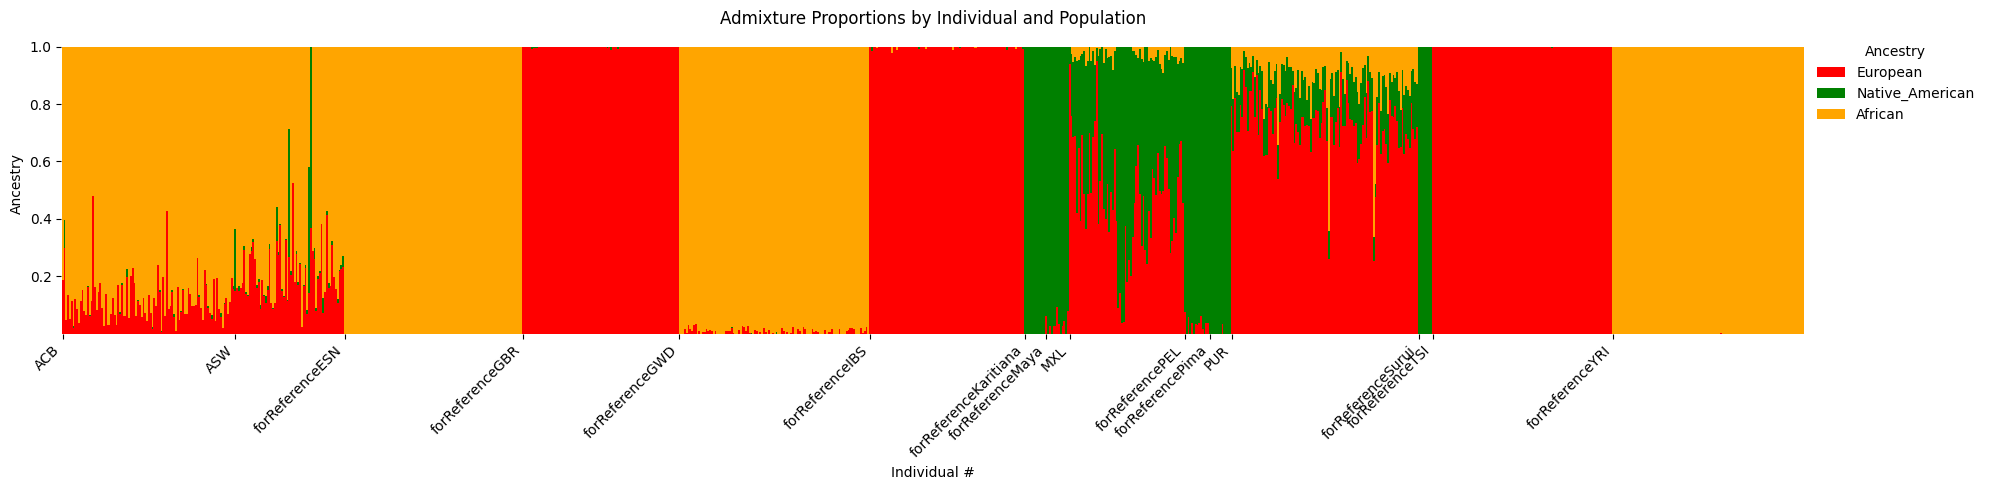

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example DataFrames for demonstration purposes
# ld_qc_df = pd.DataFrame(data, columns=['Column1', 'Column2', 'Column3', 'Column4'])
# combined_df = pd.DataFrame(data2, columns=['population'])

# Set the index of ld_qc_df to match the combined_df order
ld_qc_df.index = combined_df.index

# Define custom colors
colors = ['red', 'green', 'orange']

# Rename columns for legend
ld_qc_df.columns = ['European', 'Native_American', 'African']

# Plot
fig, ax = plt.subplots(figsize=(20, 5))

# Create the stacked bar plot with custom colors
ld_qc_df.plot(kind='bar', stacked=True, ax=ax, edgecolor='none', color=colors, width=1)

# Extract population boundaries
populations = combined_df['population'].values
tick_positions = []
tick_labels = []

# Create labels for each population group
current_pos = 0
for i, pop in enumerate(populations):
    if i == 0 or pop != populations[i - 1]:
        tick_positions.append(current_pos + len(ld_qc_df.columns) / len(populations) / 2)
        tick_labels.append(pop)
    current_pos += 1

# Set custom x-axis labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

# Customizing the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add legend with renamed columns
ax.legend(title='Ancestry', bbox_to_anchor=(1,1), fontsize='medium', labelspacing=0.5, frameon=False)

plt.xlabel('Individual #')
plt.ylabel('Ancestry')
plt.title('Admixture Proportions by Individual and Population')

plt.tight_layout()
plt.show()


<ipython-input-17-1782f529b918>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')  # You can choose from various colormaps like 'viridis', 'plasma', 'inferno', 'cividis', etc.


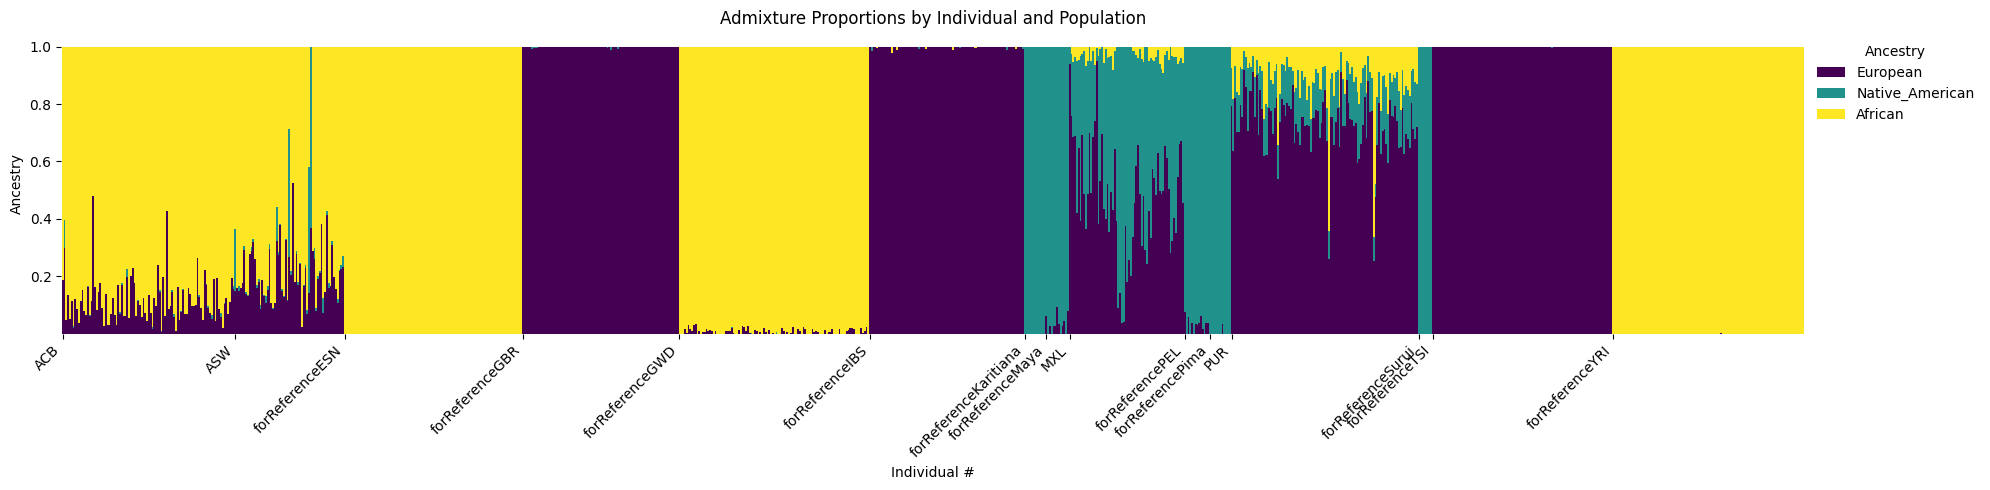

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# Example DataFrames for demonstration purposes
# ld_qc_df = pd.DataFrame(data, columns=['Column1', 'Column2', 'Column3', 'Column4'])
# combined_df = pd.DataFrame(data2, columns=['population'])

# Set the index of ld_qc_df to match the combined_df order
ld_qc_df.index = combined_df.index

# Define the number of colors you need based on the columns
num_colors = len(ld_qc_df.columns)

# Get a colormap
cmap = get_cmap('viridis')  # You can choose from various colormaps like 'viridis', 'plasma', 'inferno', 'cividis', etc.

# Generate colors from the colormap
colors = cmap(np.linspace(0, 1, num_colors))

# Rename columns for legend
ld_qc_df.columns = ['European', 'Native_American', 'African']

# Plot
fig, ax = plt.subplots(figsize=(20, 5))

# Create the stacked bar plot with custom colors
ld_qc_df.plot(kind='bar', stacked=True, ax=ax, edgecolor='none', color=colors, width=1)

# Extract population boundaries
populations = combined_df['population'].values
tick_positions = []
tick_labels = []

# Create labels for each population group
current_pos = 0
for i, pop in enumerate(populations):
    if i == 0 or pop != populations[i - 1]:
        tick_positions.append(current_pos + len(ld_qc_df.columns) / len(populations) / 2)
        tick_labels.append(pop)
    current_pos += 1

# Set custom x-axis labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

# Customizing the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add legend with renamed columns
ax.legend(title='Ancestry', bbox_to_anchor=(1,1), fontsize='medium', labelspacing=0.5, frameon=False)

plt.xlabel('Individual #')
plt.ylabel('Ancestry')
plt.title('Admixture Proportions by Individual and Population')

plt.tight_layout()
plt.show()


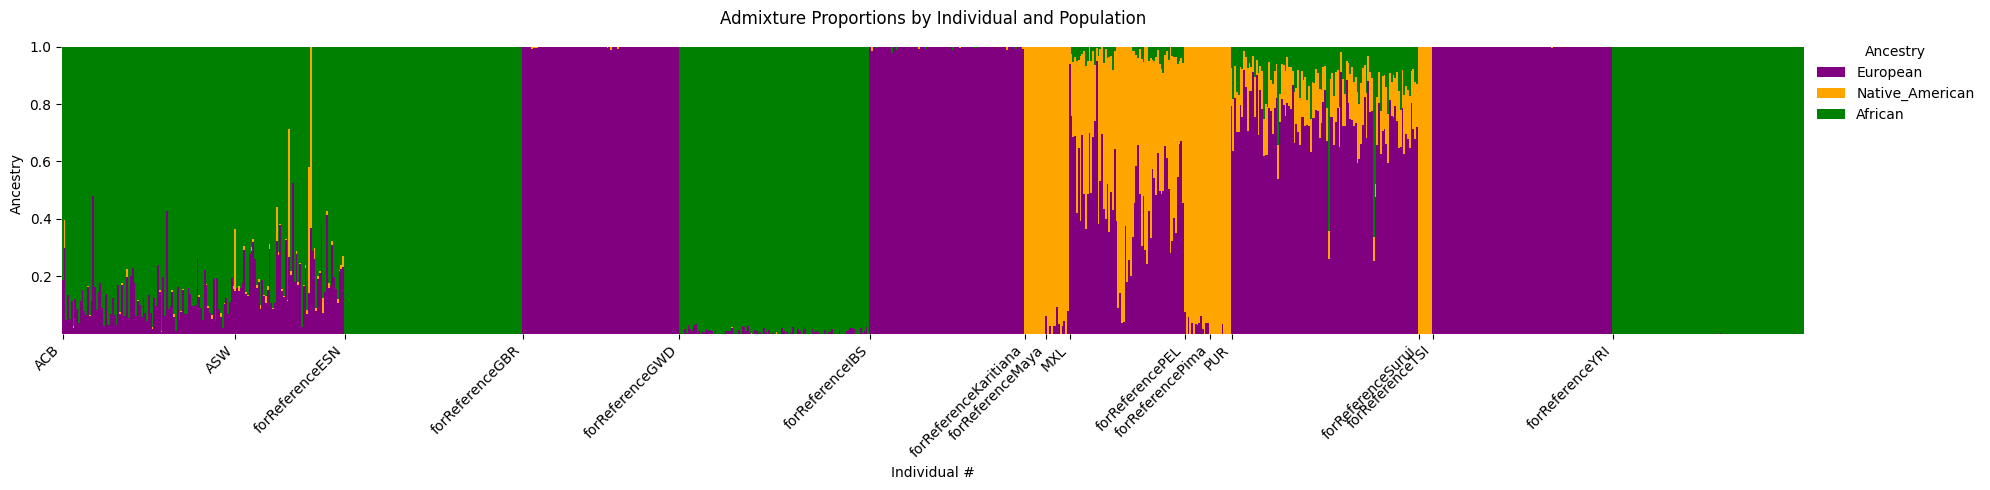

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Example DataFrames for demonstration purposes
# ld_qc_df = pd.DataFrame(data, columns=['Column1', 'Column2', 'Column3', 'Column4'])
# combined_df = pd.DataFrame(data2, columns=['population'])

# Set the index of ld_qc_df to match the combined_df order
ld_qc_df.index = combined_df.index

# Define your specific colors
colors = ['purple', 'orange', 'green']

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Number of colors needed based on columns
num_colors = len(ld_qc_df.columns)

# Generate colors from the custom colormap
color_list = cmap(np.linspace(0, 1, num_colors))

# Rename columns for legend
ld_qc_df.columns = ['European', 'Native_American', 'African']

# Plot
fig, ax = plt.subplots(figsize=(20, 5))

# Create the stacked bar plot with custom colors
ld_qc_df.plot(kind='bar', stacked=True, ax=ax, edgecolor='none', color=color_list, width=1)

# Extract population boundaries
populations = combined_df['population'].values
tick_positions = []
tick_labels = []

# Create labels for each population group
current_pos = 0
for i, pop in enumerate(populations):
    if i == 0 or pop != populations[i - 1]:
        tick_positions.append(current_pos + len(ld_qc_df.columns) / len(populations) / 2)
        tick_labels.append(pop)
    current_pos += 1

# Set custom x-axis labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')

# Customizing the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add legend with renamed columns
ax.legend(title='Ancestry', bbox_to_anchor=(1,1), fontsize='medium', labelspacing=0.5, frameon=False)

plt.xlabel('Individual #')
plt.ylabel('Ancestry')
plt.title('Admixture Proportions by Individual and Population')

plt.tight_layout()
plt.show()
